In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
annotation_path=r"../data/annotation.csv"
raw_data_path=r"../data/raw"

# Data analýza


In [15]:
df = pd.read_csv(annotation_path, index_col="id")
df

,filename,width,height,depth,name,xmin,xmax,ymin,ymax
id,,,,,,,,,
0,n02085620_10074,333,500,3,Chihuahua,25,276,10,498
1,n02085620_10131,395,495,3,Chihuahua,49,393,9,493
2,n02085620_10621,500,298,3,Chihuahua,142,335,43,250
3,n02085620_1073,345,500,3,Chihuahua,0,312,27,498
4,n02085620_10976,322,484,3,Chihuahua,90,242,104,452
...,...,...,...,...,...,...,...,...,...
22121,n02116738_9818,500,333,3,African_hunting_dog,48,499,0,332
22122,n02116738_9829,202,300,3,African_hunting_dog,0,170,39,299
22123,n02116738_9844,600,400,3,African_hunting_dog,199,473,136,348


V datasete je 22126 záznamov

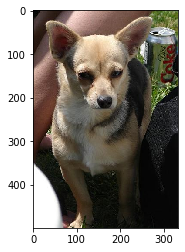

In [13]:
img = mpimg.imread(raw_data_path + "/n02085620_10074.jpg")
imgplot = plt.imshow(img)
plt.show()

In [20]:
len(df["name"].unique())

120

120 plemien psov

In [37]:
df["name"].value_counts()


Afghan_hound          287
Maltese_dog           264
Irish_wolfhound       263
Leonberg              256
Scottish_deerhound    246
                     ... 
Sussex_spaniel        153
Rottweiler            153
groenendael           152
Pekinese              152
redbone               151
Name: name, Length: 120, dtype: int64